In [16]:
from requests import get
from requests.auth import HTTPBasicAuth
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

import json
import random

YELP_TOKEN = "J-_uLug-KZ278y4HH02VuMOWEo_CQCdFmV8DO8GktBTvMgA3avhd0Rt59OVqISl9F2vhcJFXgQz401PMwZNouPTKPLZ6QvmoxbyGBiWifvX3zwAo-6EH4qP3IhbXXXYx"

# Making an HTTP request

As discussed in the slides

In [17]:
response = get(
    "https://api.yelp.com/v3/businesses/search?location=Toronto&limit=50",
    headers={"Authorization": "Bearer {}".format(YELP_TOKEN)}
)
response.reason

'OK'

In [20]:
if request.ok:
    json_response = response.json()
    response_headers = response.headers
    pprint(json_response.keys())

dict_keys(['businesses', 'total', 'region'])


In [13]:
businesses = json_response['businesses']
print(businesses[0].keys())

dict_keys(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count', 'categories', 'rating', 'coordinates', 'transactions', 'price', 'location', 'phone', 'display_phone', 'distance'])


# Access Token

Go get one of your own from https://github.com/settings/tokens! Don't just steal mine!

In [39]:
pprint([business['review_count'] for business in businesses])

[2771,
 1288,
 1595,
 1095,
 750,
 781,
 986,
 1545,
 672,
 508,
 746,
 541,
 861,
 426,
 354,
 915,
 319,
 959,
 669,
 782,
 566,
 317,
 717,
 863,
 585,
 286,
 504,
 617,
 388,
 830,
 663,
 275,
 347,
 535,
 520,
 768,
 412,
 463,
 546,
 483,
 422,
 352,
 335,
 287,
 255,
 470,
 644,
 313,
 332,
 397]


In [66]:
from bs4 import BeautifulSoup

def retrieve_review_url_for(business):
    response = get(
        "https://api.yelp.com/v3/businesses/{}/reviews".format(business['id']),
        headers={"Authorization": "Bearer {}".format(YELP_TOKEN)}
    ).json()
    return response['reviews'][0]['url']

review_urls = [retrieve_review_url_for(business) for business in businesses]

In [ ]:
reviews_by_sentiment = []

def fetch_reviews(base_url, label, pages=3):
    for offset in range(0, pages * 20 + 1, 20):
        url = '{}&sort_by={}&start={}'.format(
            base_url,
            'rating_desc' if label == 'positive' else 'rating_asc',
            offset
        )
        review_page = BeautifulSoup(get(url).text)
        for review in review_page.find_all('span', attrs={'lang': 'en'}):
            if review.parent.parent.parent.previous_sibling.find(text='Previous review') != None:
                continue
            reviews_by_sentiment.append((review.text, label))

for i, url in enumerate(review_urls):
    print('Processing URL {}'.format(i))
    fetch_reviews(url, 'positive')
    print('Total reviews after appending the positive ones: {}'.format(len(reviews_by_sentiment)))
    
    fetch_reviews(url, 'negative')
    print('Total reviews after appending the negative ones: {}'.format(len(reviews_by_sentiment)))

Processing URL 0


In [78]:
reviews_by_sentiment[22]

("It's the worst service I've ever experience. I kindly ask the server for order but she just ignore me and give me a supercilious look. Other table all served water except us I have no idea what's wrong with her . \xa0We had our lunch with no water and no dishes. \xa0When my friends was ordering she's like taking the menu away and being impatient. I went Pai many times and I love the food but after today I will NEVER EVER go there again. This waitress ruined my day.",
 'negative')

In [79]:
tokenized_reviews = [(text.split(' '), label) for (text, label) in reviews_by_sentiment]

In [89]:
from nltk.sentiment import SentimentAnalyzer
import nltk.sentiment.util
from nltk.classify import NaiveBayesClassifier

random.shuffle(tokenized_reviews)
training_docs = tokenized_reviews[:1500]
test_docs = tokenized_reviews[1500:]

print("Training: %d, Testing: %d" % (len(training_docs), len(test_docs)))

sentim_analyzer = SentimentAnalyzer()

Training: 1500, Testing: 500


In [ ]:
all_words_neg = sentim_analyzer.all_words([nltk.sentiment.util.mark_negation(doc) for doc in training_docs])

In [91]:
unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
sentim_analyzer.add_feat_extractor(nltk.sentiment.util.extract_unigram_feats, unigrams=unigram_feats)

In [92]:
training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(test_docs)

In [93]:
trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)
for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
     print('{0}: {1}'.format(key, value))

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.746
F-measure [negative]: 0.7120181405895691
F-measure [positive]: 0.7728085867620752
Precision [negative]: 0.8219895287958116
Precision [positive]: 0.6990291262135923
Recall [negative]: 0.628
Recall [positive]: 0.864


<BarContainer object of 2 artists>

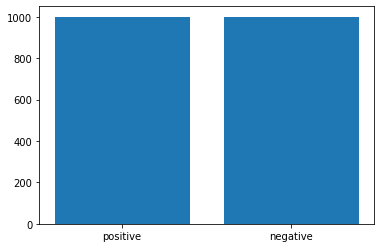

In [80]:
from collections import defaultdict

c = defaultdict(int)
for x in tokenized_reviews:
    c[x[1]] += 1

plt.bar(c.keys(), c.values())

# GraphQL